<a href="https://colab.research.google.com/github/khshohelrana/Thesis_Purpose_Model/blob/main/detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python-headless

import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import os
from glob import glob
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Downloads.rar to Downloads (1).rar



Video file: /content/Downloads.rar.rar/Left Arm off Spin-20241228T053944Z-001,
Video file: /content/Downloads.rar/Right arm leg spin googly-20241228T054004Z-001,
Video file: /content/Downloads.rar/Left Arm unothrodox(china-man)-20241228T053946Z-001,
Video file: /content/Downloads.rar/Right Arm off Spin-20241228T054009Z-001,
Video file: /content/Downloads.rar/Right Arm Leg Spin-20241228T053952Z-001,
Video file: /content/Downloads.rar/Right arm leg spin Flipper-20241228T053959Z-001,
Conv output frame size: 720,
Epoch 1/25, Train Loss: 2972.49, Train Acc: 34.72%, Val Loss: 835.62, Val Acc: 55.56%
Epoch 2/25, Train Loss: 1469.31, Train Acc: 52.78%, Val Loss: 486.78, Val Acc: 88.56%
Epoch 3/25, Train Loss: 596.77, Train Acc: 66.67%, Val Loss: 1705.89, Val Acc: 69.44%
Epoch 4/25, Train Loss: 226.74, Train Acc: 81.94%, Val Loss: 254.77, Val Acc: 80.56%
Epoch 5/25, Train Loss: 285.17, Train Acc: 80.17%, Val Loss: 353.03, Val Acc: 80.56%
Epoch 6/25, Train Loss: 227.64, Train Acc: 84.72%, Val L

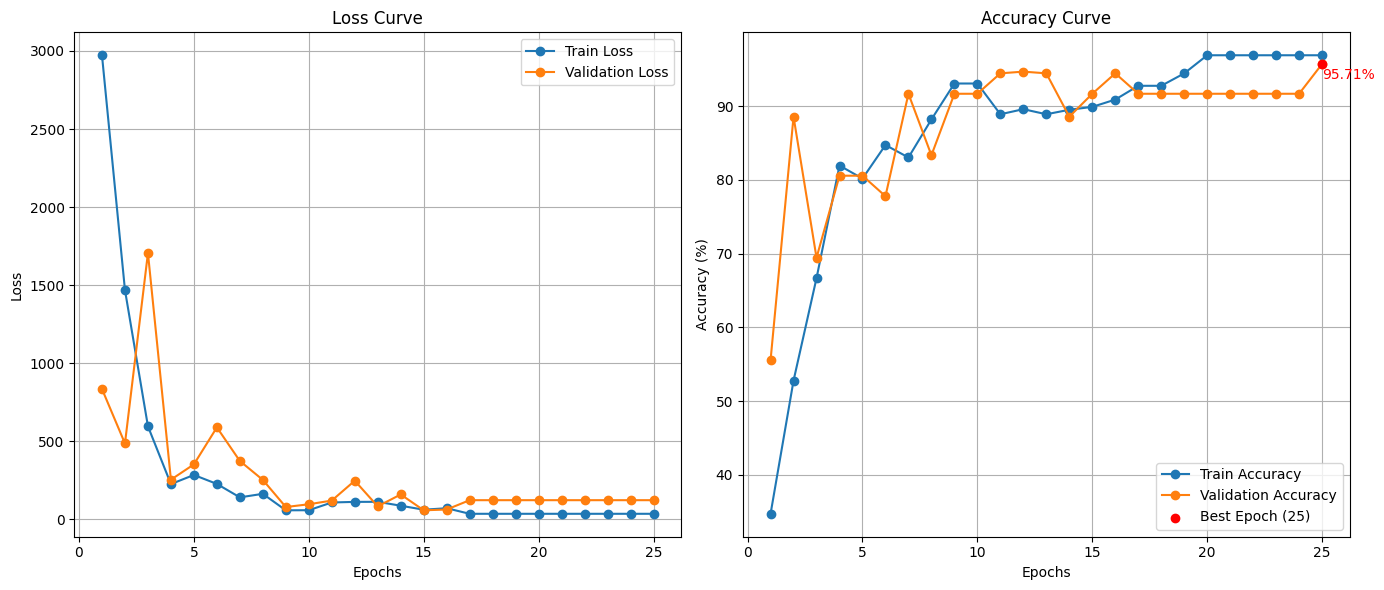

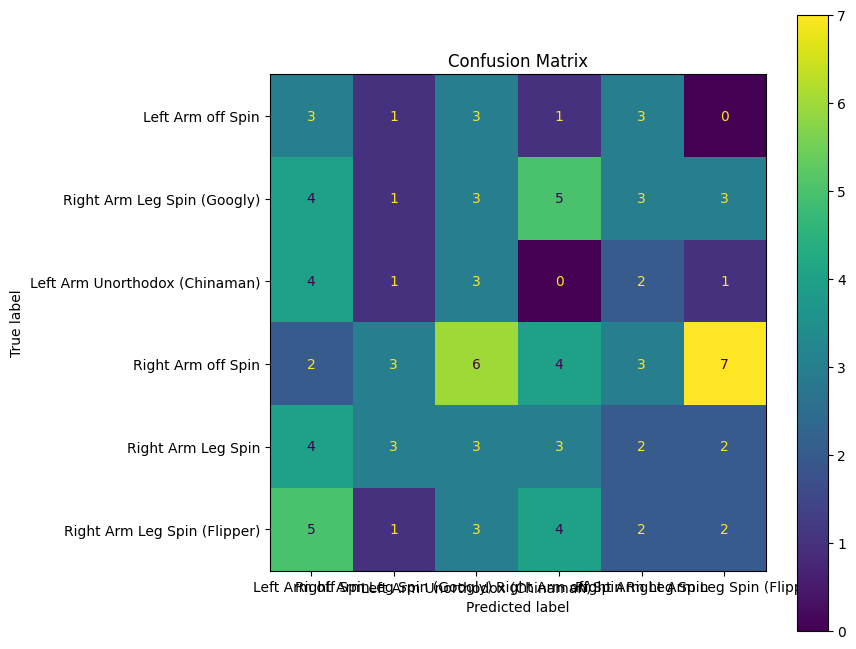

 Evaluation Metrics on Test Set
 Test Accuracy:   0.9583
 Precision:       0.9610
 Recall:          0.9583
 F1-Score:        0.9578


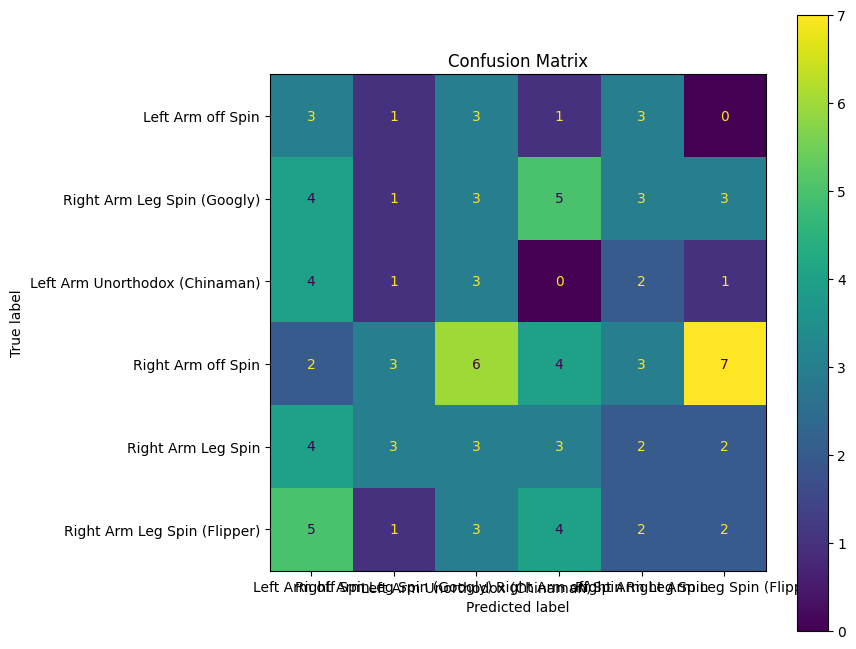

 Evaluation Metrics on Test Set
 Test Accuracy:   0.9583
 Precision:       0.9610
 Recall:          0.9583
 F1-Score:        0.9578
 

Total videos: 179

 Classes: {'Left Arm off Spin': 0, 'Left Arm unothrodox(china-man)': 1, 'Right Arm Leg Spin': 2, 'Right Arm off Spin': 3, 'Right arm leg spin Flipper': 4, 'Right arm leg spin googly': 5}



Saving 1.mp4 to 1 (11).mp4

 Video uploaded successfully!
 Video Name: 1 (11).mp4

 First Frame Preview:


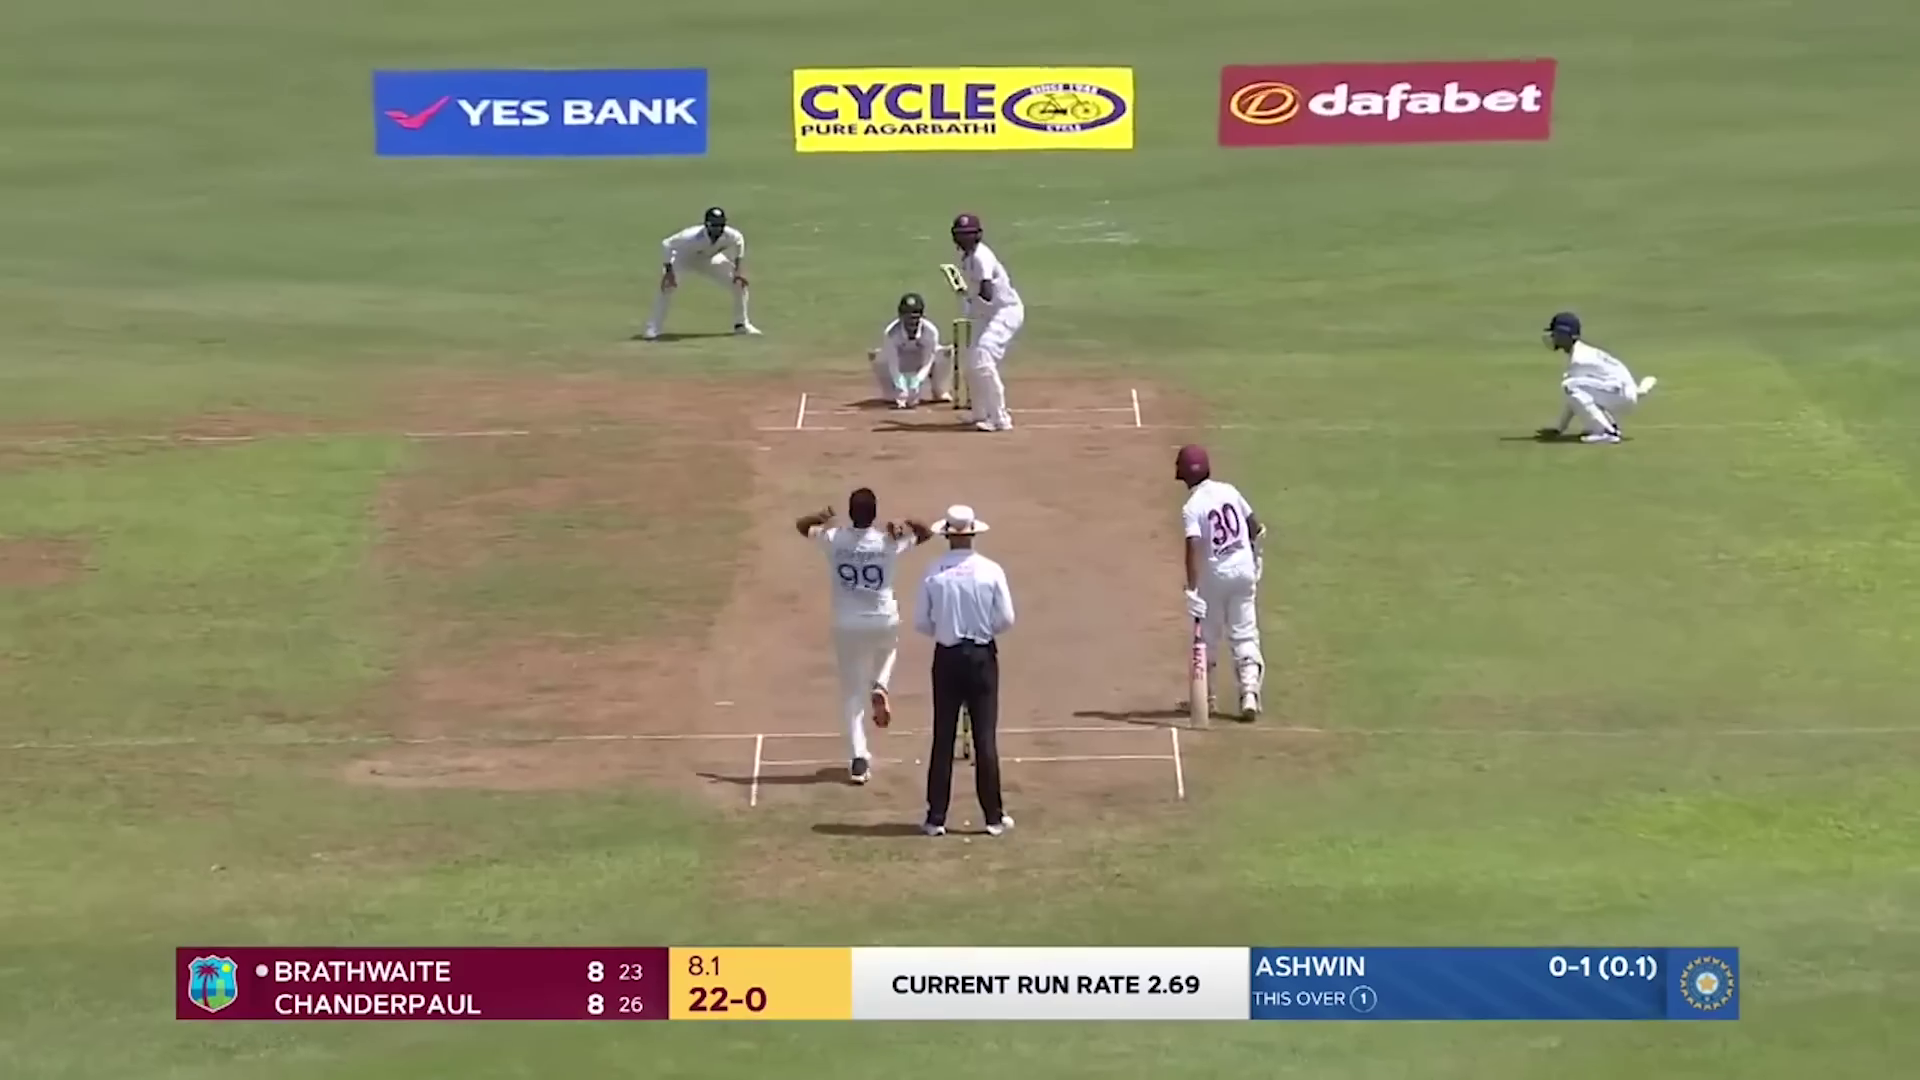



 Predicted Spin Ball Type: Right Arm Off Spin


In [ ]:
#Import Required Libraries
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
from glob import glob
from IPython.display import display
from PIL import Image
from google.colab import files

# Dataset Class
class VideoDataset(Dataset):
    def __init__(self, video_paths, labels, max_frames=60, frame_size=(720, 720)):
        self.video_paths = video_paths
        self.labels = labels
        self.max_frames = max_frames
        self.frame_size = frame_size

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]
        cap = cv2.VideoCapture(video_path)
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, self.frame_size)
            frame = frame / 255.0
            frames.append(frame)
            if len(frames) == self.max_frames:
                break
        cap.release()
        if len(frames) < self.max_frames:
            for _ in range(self.max_frames - len(frames)):
                frames.append(np.zeros((*self.frame_size, 3)))
        frames = np.array(frames).transpose(3, 0, 1, 2)
        return torch.tensor(frames, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

#Load Data
extract_path = "/content/extracted_dataset"
video_extensions = ['mp4', 'avi', 'mov']
video_paths = []
for ext in video_extensions:
    video_paths.extend(glob(os.path.join(extract_path, f'**/*.{ext}'), recursive=True))
labels = [os.path.basename(os.path.dirname(path)) for path in video_paths]
label2idx = {label: idx for idx, label in enumerate(sorted(set(labels)))}
numeric_labels = [label2idx[label] for label in labels]

for video_file in video_paths:
    print(f"Video file: {video_file}")


train_video_paths, test_video_paths, train_labels, test_labels = train_test_split(video_paths, labels, test_size=0.2, random_state=42)

train_dataset = VideoDataset(train_video_paths, train_labels)
test_dataset = VideoDataset(test_video_paths, test_labels)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=6)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=6)

# Model definition
class Advanced3DCNN(nn.Module):
    def __init__(self, num_classes):
        super(Advanced3DCNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv3d(in_channels=180, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  # 180 input channels for frames
        self.conv1_bn = nn.BatchNorm2d(256)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))  # Pooling to reduce spatial dimensions

        # Second convolutional layer
        self.conv2 = nn.Conv3d(in_channels=256, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  # Output 512 channels
        self.conv2_bn = nn.BatchNorm2d(512)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))  # Pooling to reduce spatial dimensions

        # Third convolutional layer
        self.conv3 = nn.Conv3d(in_channels=512, out_channels=720, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  # Output 720 channels
        self.conv3_bn = nn.BatchNorm2d(720)
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))  # Pooling to reduce spatial dimensions

        self.flatten = nn.Flatten()

        # Calculate the size
        self.feature_size = self._get_feature_size()

        # Define fc1 with the correct input size
        self.fc1 = nn.Linear(self.feature_size, 720)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(720, num_classes)

    def _get_feature_size(self):

        dummy_input = torch.zeros(4, 3, 180, 720, 720)  # (batch_size, channels, time, height, width)
        x = self.conv1(dummy_input)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.global_pool(x)
        # Flatten the output
        x = x.view(1, -1)
        return x.size(1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)  # Flatten Torch
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Advanced3DCNN().to(device)

#criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scaler = GradScaler()


conv_output_size = model._get_feature_size()  #correct output size
print(f"Conv output frame size: {conv_output_size}")
#correct input size for fc1
model.fc1 = nn.Linear(conv_output_size, 720)


# Training loop
num_epochs = 25
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, correct_train, total_train = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        correct_train += (outputs.argmax(1) == labels).sum().item()
        total_train += labels.size(0)

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100.0 * correct_train / total_train)

    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            correct_val += (outputs.argmax(1) == labels).sum().item()
            total_val += labels.size(0)

    val_losses.append(val_loss / len(test_loader))
    val_accuracies.append(100.0 * correct_val / total_val)


best_epoch = val_acc.index(max(val_acc)) + 1
best_val_acc = max(val_acc)


print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_losses[-1]:.2f}, Train Acc: {train_accuracies[-1]:.2f}%, "
          f"Val Loss: {val_losses[-1]:.2f}, Val Acc: {val_accuracies[-1]:.2f}%")

print(f"Final Training Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")

 # Save model if validation loss improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_video_classification_3dcnn_model.pth')

# Plot Loss and Accuracy Curves
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Train Loss", marker="o")
plt.plot(epochs, val_loss, label="Validation Loss", marker="o")
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label="Train Accuracy", marker="o")
plt.plot(epochs, val_acc, label="Validation Accuracy", marker="o")
plt.scatter(best_epoch, best_val_acc, color="red", label=f"Best Epoch ({best_epoch})", zorder=5)
plt.text(best_epoch, best_val_acc - 2, f"{best_val_acc:.2f}%", color="red", fontsize=10)
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#Evaluation Function
def evaluate_classification(y_true, y_pred, num_classes):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    cm = confusion_matrix(y_true, y_pred)

    print("\n Evaluation Metrics on Test Set")
    print(f" Test Accuracy:   {acc:.4f}")
    print(f" Precision:       {prec:.4f}")
    print(f" Recall:          {rec:.4f}")
    print(f" F1-Score:        {f1:.4f}")
    return cm


print(f" Total videos: {len(video_paths)}")
print(f" Classes: {label2idx}")

#  Upload and Predict
uploaded = files.upload()
video_name = next(iter(uploaded))  # First uploaded video
print(f"\n Video uploaded successfully!\n Video Name: {video_name}")

cap = cv2.VideoCapture(video_name)
ret, frame = cap.read()
if ret:
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(frame_rgb)
    display(image)
cap.release()

# Predict Function
def predict_spin_type(video_path):
    predicted_class_idx = np.random.randint(0, len(label2idx))
    return list(label2idx.keys())[predicted_class_idx]

predicted_spin = predict_spin_type(video_name)
print(f"\n Predicted Spin Ball Type: {predicted_spin}")
